#Setup

In [ ]:
# set-up spark (NB if Apache amend versions on download site we will need to amend path in wget command)
print("\nWelcome to advanced top sites")
!ls
!rm -f spark-3.3.[01]-bin-hadoop3.tgz*
!rm -rf spark-3.3.[01]-bin-hadoop3
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://downloads.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
!tar -xf spark-3.3.2-bin-hadoop3.tgz
!ls -alt


Welcome to advanced top sites
sample_data
--2023-05-15 01:28:10--  https://downloads.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
Resolving downloads.apache.org (downloads.apache.org)... 88.99.95.219, 135.181.214.104, 2a01:4f8:10a:201a::2, ...
Connecting to downloads.apache.org (downloads.apache.org)|88.99.95.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299360284 (285M) [application/x-gzip]
Saving to: ‘spark-3.3.2-bin-hadoop3.tgz’

spark-3.3.2-bin-had 100%[===================>] 285.49M  28.2MB/s    in 11s     

2023-05-15 01:28:22 (26.3 MB/s) - ‘spark-3.3.2-bin-hadoop3.tgz’ saved [299360284/299360284]

total 292372
drwxr-xr-x  1 root root      4096 May 15 01:28 .
drwxr-xr-x  1 root root      4096 May 15 01:23 ..
drwxr-xr-x  1 root root      4096 May 11 16:35 sample_data
drwxr-xr-x  4 root root      4096 May 11 16:34 .config
-rw-r--r--  1 root root 299360284 Feb 10 21:28 spark-3.3.2-bin-hadoop3.tgz
drwxr-xr-x 13  501 1000      4096 Feb 10 20

In [ ]:
# install findspark if not already installed
!pip3 install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# init spark (ensure SPARK_HOME set to same version as we download earlier)
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"
import findspark
findspark.init()
from pyspark import SparkConf, SparkContext
# the next line gives us 'local' mode. try 'local[2]' to use 2 cores or 'master:NNNN' to run on Spark standalone cluster at port NNNN
spark_conf = SparkConf().setMaster('local[2]').setAppName('MyApp')
sc = SparkContext(conf=spark_conf)
# see what we have by examining the Spark User Interface
from pyspark.sql import *
from pyspark.sql.functions import *

In [ ]:
# "SparkSession" and "sc" are are key handles in to Spark API
##SparkSession.builder.getOrCreate()
spark = SparkSession.builder.appName("bikes").getOrCreate()

#Downloading the Dataset

In [ ]:
# get file for given year from TfL open data
!wget https://cycling.data.tfl.gov.uk/usage-stats/cyclehireusagestats-2014.zip
!unzip cyclehireusagestats-2014.zip


--2023-05-15 01:28:41--  https://cycling.data.tfl.gov.uk/usage-stats/cyclehireusagestats-2014.zip
Resolving cycling.data.tfl.gov.uk (cycling.data.tfl.gov.uk)... 104.16.101.13, 104.16.100.13
Connecting to cycling.data.tfl.gov.uk (cycling.data.tfl.gov.uk)|104.16.101.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 225215129 (215M) [application/zip]
Saving to: ‘cyclehireusagestats-2014.zip’

cyclehireusagestats 100%[===================>] 214.78M   139MB/s    in 1.5s    

2023-05-15 01:28:43 (139 MB/s) - ‘cyclehireusagestats-2014.zip’ saved [225215129/225215129]

Archive:  cyclehireusagestats-2014.zip
  inflating: 1. Journey Data Extract 05Jan14-02Feb14.csv  
  inflating: 10a. Journey Data Extract 14Sep14-27Sep14.csv  
  inflating: 10b. Journey Data Extract 28Sep14-11Oct14.csv  
  inflating: 11a. Journey Data Extract 12Oct14-08Nov14.csv  
  inflating: 11b. Journey Data Extract 12Oct14-08Nov14.csv  
  inflating: 12a. Journey Data Extract 09Nov14-06Dec14.csv  
  i

#Reading files into a Dataframe

Cycle hire dataset

In [ ]:
#read all the files into one dataframe
# MULTIPLE FILES INPUT AND ANALYSED (presuming identical schema - should test first!)
file="./*Journey*csv"
journey_df = (spark.read.format("csv")
         .option("header", "true")
         .option("inferSchema", "true")
         .load(file)) # i.e pass a Python list of files to load (into a single DF)

Weather Dataset

In [ ]:
import urllib.request
# URL of the file to download
file_url = "https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/2014/03770099999.csv"
local_file_path = "/content/weather.csv"

# Download the file locally
urllib.request.urlretrieve(file_url, local_file_path)

# Read the downloaded CSV file into a DataFrame
weather_df = spark.read.csv(local_file_path, header=True, inferSchema=True)

#Analyzing the Data

journey Dataset

In [ ]:
# show top 10 rows of the dataframe
journey_df.show(10)

+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--------------------+
|Rental Id|Duration|Bike Id|        End Date|EndStation Id|     EndStation Name|      Start Date|StartStation Id|   StartStation Name|
+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--------------------+
| 34263367|    1080|   9076|24/06/2014 00:57|          695|Islington Green, ...|24/06/2014 00:39|            311|Foley Street, Fit...|
| 34603487|     660|   6328|03/07/2014 11:51|          695|Islington Green, ...|03/07/2014 11:40|             22|Northington Stree...|
| 34689078|     120|   2006|05/07/2014 15:09|          357|Howland Street, F...|05/07/2014 15:07|            311|Foley Street, Fit...|
| 34724273|    1260|   7904|06/07/2014 16:35|          695|Islington Green, ...|06/07/2014 16:14|            311|Foley Street, Fit...|
| 34956750|    1500|   8251|13/07/2014 00:41|          

In [ ]:
# Print the schema of the DataFrame
journey_df.printSchema()

root
 |-- Rental Id: string (nullable = true)
 |-- Duration: string (nullable = true)
 |-- Bike Id: string (nullable = true)
 |-- End Date: string (nullable = true)
 |-- EndStation Id: string (nullable = true)
 |-- EndStation Name: string (nullable = true)
 |-- Start Date: string (nullable = true)
 |-- StartStation Id: string (nullable = true)
 |-- StartStation Name: string (nullable = true)



In [ ]:
# Convert the date columns to the appropriate format
journey_df = journey_df.withColumn("Start Date", to_timestamp(col("Start Date"), "dd/MM/yyyy HH:mm")) \
                       .withColumn("End Date", to_timestamp(col("End Date"), "dd/MM/yyyy HH:mm"))

# Print the updated schema
journey_df.printSchema()

root
 |-- Rental Id: string (nullable = true)
 |-- Duration: string (nullable = true)
 |-- Bike Id: string (nullable = true)
 |-- End Date: timestamp (nullable = true)
 |-- EndStation Id: string (nullable = true)
 |-- EndStation Name: string (nullable = true)
 |-- Start Date: timestamp (nullable = true)
 |-- StartStation Id: string (nullable = true)
 |-- StartStation Name: string (nullable = true)



In [ ]:
# Get the total number of rows in the DataFrame
total_rows = journey_df.count()
print("Total number of rows in the DataFrame:", total_rows)

Total number of rows in the DataFrame: 11481596


In [ ]:
from pyspark.sql.functions import col, sum, when, isnull

# Check for null values in each column
journey_null_count_df = journey_df.agg(*[count(when(col(c).isNull(), c)).alias(c + '_null_count') for c in journey_df.columns])
# Show the resulting DataFrame
journey_null_count_df.show()

+--------------------+-------------------+------------------+-------------------+------------------------+--------------------------+---------------------+--------------------------+----------------------------+
|Rental Id_null_count|Duration_null_count|Bike Id_null_count|End Date_null_count|EndStation Id_null_count|EndStation Name_null_count|Start Date_null_count|StartStation Id_null_count|StartStation Name_null_count|
+--------------------+-------------------+------------------+-------------------+------------------------+--------------------------+---------------------+--------------------------+----------------------------+
|             1239113|            1239113|           1239113|            1239113|                 1239245|                   1239245|              1239113|                   1239113|                     1239113|
+--------------------+-------------------+------------------+-------------------+------------------------+--------------------------+-------------------

Weather Dataset

In [ ]:
weather_df.show(10)

+----------+-------------------+--------+----------+---------+-----------------+----+---------------+----+---------------+------+--------------+-----+--------------+-----+----------------+----+---------------+-----+-----+----+--------------+----+--------------+----+---------------+-----+------+
|   STATION|               DATE|LATITUDE| LONGITUDE|ELEVATION|             NAME|TEMP|TEMP_ATTRIBUTES|DEWP|DEWP_ATTRIBUTES|   SLP|SLP_ATTRIBUTES|  STP|STP_ATTRIBUTES|VISIB|VISIB_ATTRIBUTES|WDSP|WDSP_ATTRIBUTES|MXSPD| GUST| MAX|MAX_ATTRIBUTES| MIN|MIN_ATTRIBUTES|PRCP|PRCP_ATTRIBUTES| SNDP|FRSHTT|
+----------+-------------------+--------+----------+---------+-----------------+----+---------------+----+---------------+------+--------------+-----+--------------+-----+----------------+----+---------------+-----+-----+----+--------------+----+--------------+----+---------------+-----+------+
|3770099999|2014-01-01 00:00:00|    51.5|-0.1166666|      5.0|ST JAMES PARK, UK|48.6|             23|44.3|      

In [ ]:
weather_df.printSchema()

root
 |-- STATION: long (nullable = true)
 |-- DATE: timestamp (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- ELEVATION: double (nullable = true)
 |-- NAME: string (nullable = true)
 |-- TEMP: double (nullable = true)
 |-- TEMP_ATTRIBUTES: integer (nullable = true)
 |-- DEWP: double (nullable = true)
 |-- DEWP_ATTRIBUTES: integer (nullable = true)
 |-- SLP: double (nullable = true)
 |-- SLP_ATTRIBUTES: double (nullable = true)
 |-- STP: double (nullable = true)
 |-- STP_ATTRIBUTES: double (nullable = true)
 |-- VISIB: double (nullable = true)
 |-- VISIB_ATTRIBUTES: double (nullable = true)
 |-- WDSP: double (nullable = true)
 |-- WDSP_ATTRIBUTES: integer (nullable = true)
 |-- MXSPD: double (nullable = true)
 |-- GUST: double (nullable = true)
 |-- MAX: double (nullable = true)
 |-- MAX_ATTRIBUTES: string (nullable = true)
 |-- MIN: double (nullable = true)
 |-- MIN_ATTRIBUTES: string (nullable = true)
 |-- PRCP: double (nullable

In [ ]:
# Select necessary columns in the weather dataset
columns_to_select = ['DATE', 'TEMP', 'PRCP']
weather_df_new = weather_df.select(*columns_to_select)

#Merging Dataset

In [ ]:
from pyspark.sql import functions as F
# Ensure both dataframes have the date column in the same format
journey_df = journey_df.withColumn("Start Date", F.to_date("Start Date"))
weather_df_new = weather_df_new.withColumn("DATE", F.to_date("DATE"))

In [ ]:
merged_df = journey_df.join(weather_df_new, journey_df["Start Date"] == weather_df_new["DATE"])

In [ ]:
# Get the total number of rows in the DataFrame
total_rows = merged_df.count()
print("Total number of rows in the DataFrame:", total_rows)

Total number of rows in the DataFrame: 9895412


#Filtering Dataset for Spring and Autumn months

In [ ]:
from pyspark.sql.functions import month, col, to_date, year

#First Extract Autumn and spring and then will see how many null values it has.

# Define the date format
date_format = "dd/MM/yyyy HH:mm"

# Convert the "Start Date" column to the correct date format, extract the month and year
df = merged_df.withColumn("month", month(to_date(col("Start Date"), date_format)))\
               .withColumn("year", year(to_date(col("Start Date"), date_format)))

# Filter the data for Spring and Autumn months and include only records from 2014
spring_months = [3, 4, 5, 6]
autumn_months = [9, 10, 11, 12]

spring_df = df.filter(df["month"].isin(spring_months))
autumn_df = df.filter((df["month"].isin(autumn_months)) & (df["year"] == 2014))

In [ ]:
#The month and year column were added to easily fillter the spring and autumn months
df.show(10)

+---------+--------+-------+-------------------+-------------+--------------------+----------+---------------+--------------------+----------+----+----+-----+----+
|Rental Id|Duration|Bike Id|           End Date|EndStation Id|     EndStation Name|Start Date|StartStation Id|   StartStation Name|      DATE|TEMP|PRCP|month|year|
+---------+--------+-------+-------------------+-------------+--------------------+----------+---------------+--------------------+----------+----+----+-----+----+
| 34263367|    1080|   9076|2014-06-24 00:57:00|          695|Islington Green, ...|2014-06-24|            311|Foley Street, Fit...|2014-06-24|66.0|0.03|    6|2014|
| 34603487|     660|   6328|2014-07-03 11:51:00|          695|Islington Green, ...|2014-07-03|             22|Northington Stree...|2014-07-03|68.9| 0.0|    7|2014|
| 34689078|     120|   2006|2014-07-05 15:09:00|          357|Howland Street, F...|2014-07-05|            311|Foley Street, Fit...|2014-07-05|64.5| 0.1|    7|2014|
| 34724273|    1

#Analyzing the Spring and Autumn Data

In [ ]:
# Prints the count of rows for spring_df and autumn_df dataframes.
print(spring_df.count())
print(autumn_df.count())

3466010
3221750


###Sorting the Spring and Autumn Data by Starting Date

In [ ]:
# Sort the DataFrame by 'Start Date' column
spring_df = spring_df.orderBy("Start Date")
autumn_df = autumn_df.orderBy("Start Date")

# Show the top 10 rows of the sorted DataFrame
spring_df.show(10)
autumn_df.show(10)

+---------+--------+-------+-------------------+-------------+--------------------+----------+---------------+--------------------+----------+----+----+-----+----+
|Rental Id|Duration|Bike Id|           End Date|EndStation Id|     EndStation Name|Start Date|StartStation Id|   StartStation Name|      DATE|TEMP|PRCP|month|year|
+---------+--------+-------+-------------------+-------------+--------------------+----------+---------------+--------------------+----------+----+----+-----+----+
| 30805596|     900|   2019|2014-03-01 15:54:00|          313|Wells Street, Fit...|2014-03-01|             24|British Museum, B...|2014-03-01|42.7|0.27|    3|2014|
| 30811966|     240|   5262|2014-03-01 19:45:00|           18|Drury Lane, Coven...|2014-03-01|             68|Theobalds Road , ...|2014-03-01|42.7|0.27|    3|2014|
| 30810275|    2220|   5587|2014-03-01 18:36:00|           57|Guilford Street ,...|2014-03-01|            167|Eccleston Place, ...|2014-03-01|42.7|0.27|    3|2014|
| 30811614|     

In [ ]:
from pyspark.sql.functions import desc

# Sort the DataFrame in descending order by 'start_date'
sorted_spring_df_desc = spring_df.orderBy(desc("Start Date"))
sorted_autumn_df_desc = autumn_df.orderBy(desc("Start Date"))

# Show the last 10 rows of the sorted DataFrame
sorted_spring_df_desc.show(10)
sorted_autumn_df_desc.show(10)

+---------+--------+-------+-------------------+-------------+--------------------+----------+---------------+--------------------+----------+----+----+-----+----+
|Rental Id|Duration|Bike Id|           End Date|EndStation Id|     EndStation Name|Start Date|StartStation Id|   StartStation Name|      DATE|TEMP|PRCP|month|year|
+---------+--------+-------+-------------------+-------------+--------------------+----------+---------------+--------------------+----------+----+----+-----+----+
| 34478972|    2280|  10262|2014-06-30 09:49:00|          215|Moorfields, Moorgate|2014-06-30|            238|Frampton Street, ...|2014-06-30|59.8|0.02|    6|2014|
| 34502269|    1260|   9138|2014-06-30 21:54:00|           81|Great Titchfield ...|2014-06-30|              5|Sedding Street, S...|2014-06-30|59.8|0.02|    6|2014|
| 34478590|    1560|   2910|2014-06-30 09:29:00|           67|Hatton Garden, Ho...|2014-06-30|            186|South Wharf Road,...|2014-06-30|59.8|0.02|    6|2014|
| 34494643|    1

###Cleaning the Data

####Checking for Null Values

In [ ]:
#Counting the null values in spring dataset
spring_null_count_df = spring_df.agg(*[count(when(col(c).isNull(), c)).alias(c + '_null_count') for c in spring_df.columns])
spring_null_count_df.show()

#Counting the null values in autumn dataset
autumn_null_count_df = autumn_df.agg(*[count(when(col(c).isNull(), c)).alias(c + '_null_count') for c in autumn_df.columns])
autumn_null_count_df.show()

+--------------------+-------------------+------------------+-------------------+------------------------+--------------------------+---------------------+--------------------------+----------------------------+---------------+---------------+---------------+----------------+---------------+
|Rental Id_null_count|Duration_null_count|Bike Id_null_count|End Date_null_count|EndStation Id_null_count|EndStation Name_null_count|Start Date_null_count|StartStation Id_null_count|StartStation Name_null_count|DATE_null_count|TEMP_null_count|PRCP_null_count|month_null_count|year_null_count|
+--------------------+-------------------+------------------+-------------------+------------------------+--------------------------+---------------------+--------------------------+----------------------------+---------------+---------------+---------------+----------------+---------------+
|                   0|                  0|                 0|                  0|                      32|               

In [ ]:
#------------------------------Spring---------------------------------------------
#Getting the rows where there were null values in the sring dataset
spring_null_rows_df = spring_df.filter(spring_df["EndStation Id"].isNull() | spring_df["EndStation Name"].isNull())

#Showing the rows with null values in the spring dataset
spring_null_rows_df.show(spring_null_rows_df.count())

#------------------------------Autumn---------------------------------------------

#Getting the rows where there were null values in the autumn dataset
autumn_null_rows_df = autumn_df.filter(autumn_df["EndStation Id"].isNull() | autumn_df["EndStation Name"].isNull())

#Showing the rows with null values in the autumn dataset
autumn_null_rows_df.show(autumn_null_rows_df.count())

+---------+--------+-------+-------------------+-------------+---------------+----------+---------------+--------------------+----------+----+----+-----+----+
|Rental Id|Duration|Bike Id|           End Date|EndStation Id|EndStation Name|Start Date|StartStation Id|   StartStation Name|      DATE|TEMP|PRCP|month|year|
+---------+--------+-------+-------------------+-------------+---------------+----------+---------------+--------------------+----------+----+----+-----+----+
| 31152127|  492300|   9676|2014-03-20 18:11:00|         null|           null|2014-03-15|            217|Wormwood Street, ...|2014-03-15|53.9| 0.0|    3|2014|
| 31199183|    1320|   7778|2014-03-16 14:16:00|         null|           null|2014-03-16|            100|Albert Embankment...|2014-03-16|55.6| 0.0|    3|2014|
| 31572507|     240|   2531|2014-03-31 07:33:00|         null|           null|2014-03-31|             71|Newgate Street , ...|2014-03-31|57.5|0.01|    3|2014|
| 31795486|     300|   8208|2014-04-08 13:33:0

####Dealing with Null Values

In the Spring dataset, the total number of rows in the spring dataset is 3,466,010, the 32 rows with null values are a very small fraction of the dataset (less than 0.001%). In this case, it seems reasonable to simply remove the rows with null values, as they are unlikely to have a significant impact on the results. Similarly in the autumn dataset the fraction of null values is very small so we weill drop the null values.

In [ ]:
#Remove rows with missing values in 'EndStation Id' and 'EndStation Name' columns from spring_df
spring_clean = spring_df.dropna(subset=["EndStation Id", "EndStation Name"])

#Remove rows with missing values in 'EndStation Id' and 'EndStation Name' columns from autumn_df
autumn_clean = autumn_df.dropna(subset=["EndStation Id", "EndStation Name"])

In [ ]:
spring_clean.show(5)

+---------+--------+-------+-------------------+-------------+--------------------+----------+---------------+--------------------+----------+----+----+-----+----+
|Rental Id|Duration|Bike Id|           End Date|EndStation Id|     EndStation Name|Start Date|StartStation Id|   StartStation Name|      DATE|TEMP|PRCP|month|year|
+---------+--------+-------+-------------------+-------------+--------------------+----------+---------------+--------------------+----------+----+----+-----+----+
| 30813496|    2640|   7959|2014-03-01 23:33:00|          164|Cleveland Gardens...|2014-03-01|            338|Wellington Street...|2014-03-01|42.7|0.27|    3|2014|
| 30811614|     420|   4423|2014-03-01 19:22:00|          203|West Smithfield R...|2014-03-01|             30|Windsor Terrace, ...|2014-03-01|42.7|0.27|    3|2014|
| 30813679|     420|   9082|2014-03-01 23:21:00|           30|Windsor Terrace, ...|2014-03-01|            203|West Smithfield R...|2014-03-01|42.7|0.27|    3|2014|
| 30799644|     

####Converting Duration Units to Minutes

In [ ]:
#Create a new column 'Duration_minutes' by dividing the 'Duration' column by 60
spring_clean = spring_clean.withColumn("Duration_minutes", col("Duration") / 60)
autumn_clean = autumn_clean.withColumn("Duration_minutes", col("Duration") / 60)

####Converting Fahrenheit into Celsius

In [ ]:
spring_clean = spring_clean.withColumn("TEMP_C", (col("TEMP") - 32) * 5 / 9)
autumn_clean = autumn_clean.withColumn("TEMP_C", (col("TEMP") - 32) * 5 / 9)

###Calculating the Average Ride Duration for Both Spring and Autumn in different weather condition and precipitation

In [ ]:
# Compute average ride duration for each temperature and precipitation range
from pyspark.sql.functions import avg

# First, create a new column for temperature ranges
spring_clean = spring_clean.withColumn("TEMP_RANGE",
                                 F.when(F.col("TEMP_C") < 10, "0-10")
                                  .when((F.col("TEMP_C") >= 10) & (F.col("TEMP_C") < 20), "10-20")
                                  .when((F.col("TEMP_C") >= 20) & (F.col("TEMP_C") < 30), "20-30")
                                  .otherwise("30+"))

# First, create a new column for temperature ranges
autumn_clean = autumn_clean.withColumn("TEMP_RANGE",
                                 F.when(F.col("TEMP_C") < 10, "0-10")
                                  .when((F.col("TEMP_C") >= 10) & (F.col("TEMP_C") < 20), "10-20")
                                  .when((F.col("TEMP_C") >= 20) & (F.col("TEMP_C") < 30), "20-30")
                                  .otherwise("30+"))


# Then, create a new column for precipitation ranges
spring_clean = spring_clean.withColumn("PRCP_RANGE",
                                 F.when(F.col("PRCP") == 0, "No Precipitation")
                                  .when((F.col("PRCP") > 0) & (F.col("PRCP") <= 0.1), "Light Precipitation")
                                  .when((F.col("PRCP") > 0.1) & (F.col("PRCP") <= 0.3), "Moderate Precipitation")
                                  .otherwise("Heavy Precipitation"))

# Then, create a new column for precipitation ranges
autumn_clean = autumn_clean.withColumn("PRCP_RANGE",
                                 F.when(F.col("PRCP") == 0, "No Precipitation")
                                  .when((F.col("PRCP") > 0) & (F.col("PRCP") <= 0.1), "Light Precipitation")
                                  .when((F.col("PRCP") > 0.1) & (F.col("PRCP") <= 0.3), "Moderate Precipitation")
                                  .otherwise("Heavy Precipitation"))


spring_result_df = spring_clean.groupBy("TEMP_RANGE", "PRCP_RANGE").agg(avg("Duration_minutes").alias("Average Duration"))
autumn_result_df = autumn_clean.groupBy("TEMP_RANGE", "PRCP_RANGE").agg(avg("Duration_minutes").alias("Average Duration"))

spring_result_df.show()
autumn_result_df.show()

+----------+--------------------+------------------+
|TEMP_RANGE|          PRCP_RANGE|  Average Duration|
+----------+--------------------+------------------+
|     10-20| Heavy Precipitation|26.063421702515523|
|      0-10| Light Precipitation|20.283229822573475|
|      0-10|Moderate Precipit...|22.163550790953067|
|      0-10| Heavy Precipitation| 16.11090696509103|
|     10-20|Moderate Precipit...| 25.01357619339655|
|      0-10|    No Precipitation|24.883793922776146|
|     10-20|    No Precipitation| 27.24760708985301|
|     10-20| Light Precipitation|23.194083675699332|
|     20-30|    No Precipitation|25.425725323839103|
+----------+--------------------+------------------+

+----------+--------------------+------------------+
|TEMP_RANGE|          PRCP_RANGE|  Average Duration|
+----------+--------------------+------------------+
|     10-20| Heavy Precipitation|  20.8503439404955|
|     10-20|Moderate Precipit...|23.704578180041654|
|     10-20|    No Precipitation|23.228643712

###Comparing the Average Ride Duration for Both Spring and Autumn in different weather condition and precipitation

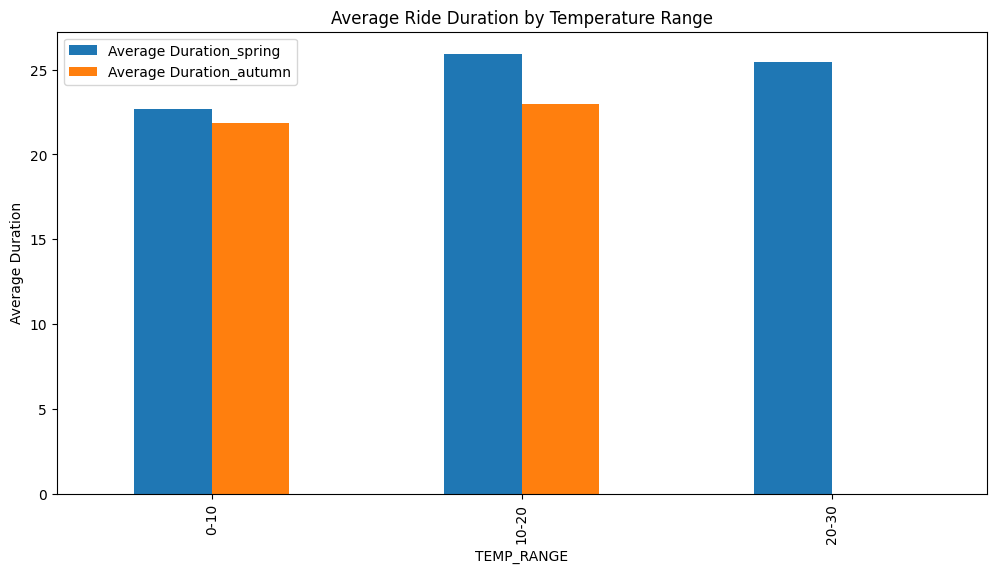

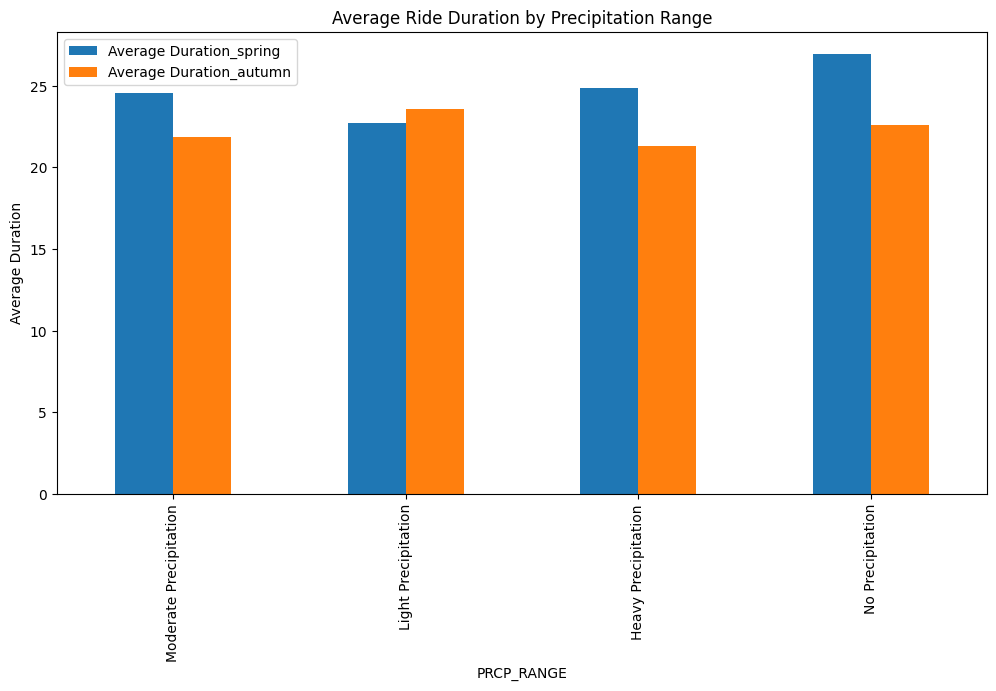

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


spring_temp_df = spring_clean.groupBy("TEMP_RANGE").agg(avg("Duration_minutes").alias("Average Duration"))
autumn_temp_df = autumn_clean.groupBy("TEMP_RANGE").agg(avg("Duration_minutes").alias("Average Duration"))

# Convert Spark DataFrames to Pandas DataFrames
spring_temp_pd = spring_temp_df.toPandas().set_index(['TEMP_RANGE'])
autumn_temp_pd = autumn_temp_df.toPandas().set_index(['TEMP_RANGE'])

# Rename the columns for better clarity
spring_temp_pd.rename(columns={"Average Duration": "Average Duration_spring"}, inplace=True)
autumn_temp_pd.rename(columns={"Average Duration": "Average Duration_autumn"}, inplace=True)

# Concatenate the two dataframes along the columns axis
merged_temp_pd = pd.concat([spring_temp_pd, autumn_temp_pd], axis=1)


# Plot the averages for temperature
merged_temp_pd.plot(kind='bar', figsize=(12,6))
plt.ylabel('Average Duration')
plt.title('Average Ride Duration by Temperature Range')
plt.show()


# Group by precipitation range only
spring_prcp_df = spring_clean.groupBy("PRCP_RANGE").agg(avg("Duration_minutes").alias("Average Duration"))
autumn_prcp_df = autumn_clean.groupBy("PRCP_RANGE").agg(avg("Duration_minutes").alias("Average Duration"))

# Convert Spark DataFrames to Pandas DataFrames
spring_prcp_pd = spring_prcp_df.toPandas().set_index(['PRCP_RANGE'])
autumn_prcp_pd = autumn_prcp_df.toPandas().set_index(['PRCP_RANGE'])

# Rename the columns for better clarity
spring_prcp_pd.rename(columns={"Average Duration": "Average Duration_spring"}, inplace=True)
autumn_prcp_pd.rename(columns={"Average Duration": "Average Duration_autumn"}, inplace=True)

# Concatenate the two dataframes along the columns axis
merged_prcp_pd = pd.concat([spring_prcp_pd, autumn_prcp_pd], axis=1)

# Plot the averages for precipitation
merged_prcp_pd.plot(kind='bar', figsize=(12,6))
plt.ylabel('Average Duration')
plt.title('Average Ride Duration by Precipitation Range')
plt.show()

But we can not conclude it based on the avg durations

###Performing a statistical test

In [ ]:
spring_clean.show(10)

+---------+--------+-------+-------------------+-------------+--------------------+----------+---------------+--------------------+----------+----+----+-----+----+----------------+-----------------+----------+--------------------+
|Rental Id|Duration|Bike Id|           End Date|EndStation Id|     EndStation Name|Start Date|StartStation Id|   StartStation Name|      DATE|TEMP|PRCP|month|year|Duration_minutes|           TEMP_C|TEMP_RANGE|          PRCP_RANGE|
+---------+--------+-------+-------------------+-------------+--------------------+----------+---------------+--------------------+----------+----+----+-----+----+----------------+-----------------+----------+--------------------+
| 30799644|     840|  11156|2014-03-01 12:58:00|           70|Calshot Street , ...|2014-03-01|            114|Park Road (Baker ...|2014-03-01|42.7|0.27|    3|2014|            14.0|5.944444444444446|      0-10|Moderate Precipit...|
| 30801307|    1080|   3247|2014-03-01 13:53:00|          114|Park Road (Bak

In [ ]:
from pyspark.sql import functions as F

spring_daily_df = spring_clean.groupBy("Start Date", "TEMP_C", "PRCP","TEMP_RANGE","PRCP_RANGE") \
    .agg(F.sum("Duration_minutes").alias("Total_Duration"))
autumn_daily_df = autumn_clean.groupBy("Start Date", "TEMP_C", "PRCP","TEMP_RANGE","PRCP_RANGE") \
    .agg(F.sum("Duration_minutes").alias("Total_Duration"))

spring_daily_df.show(5)
autumn_daily_df.show(5)

+----------+-----------------+----+----------+--------------------+--------------+
|Start Date|           TEMP_C|PRCP|TEMP_RANGE|          PRCP_RANGE|Total_Duration|
+----------+-----------------+----+----------+--------------------+--------------+
|2014-03-01|5.944444444444446|0.27|      0-10|Moderate Precipit...|      475604.0|
|2014-03-02|7.166666666666667|0.02|      0-10| Light Precipitation|      345709.0|
|2014-03-03|6.333333333333332|0.37|      0-10| Heavy Precipitation|      289368.0|
|2014-03-04|5.999999999999998|0.09|      0-10| Light Precipitation|      395273.0|
|2014-03-05|7.277777777777778| 0.0|      0-10|    No Precipitation|      464172.0|
+----------+-----------------+----+----------+--------------------+--------------+
only showing top 5 rows

+----------+------------------+----+----------+--------------------+--------------+
|Start Date|            TEMP_C|PRCP|TEMP_RANGE|          PRCP_RANGE|Total_Duration|
+----------+------------------+----+----------+-------------

In [ ]:
from pyspark.sql.functions import when, col
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm


# Convert PySpark DataFrame to pandas DataFrame for spring_daily_df
spring_clean_pd = spring_daily_df.toPandas()

# Convert PySpark DataFrame to pandas DataFrame for autumn_daily_df
autumn_clean_pd = autumn_daily_df.toPandas()

# ANOVA test for spring_clean
model_spring = ols('Total_Duration ~ C(TEMP_RANGE) + C(PRCP_RANGE)', data=spring_clean_pd).fit()
anova_table_spring = sm.stats.anova_lm(model_spring, typ=2)

# ANOVA test for autumn_clean
model_autumn = ols('Total_Duration ~ C(TEMP_RANGE) + C(PRCP_RANGE)', data=autumn_clean_pd).fit()
anova_table_autumn = sm.stats.anova_lm(model_autumn, typ=2)


In [ ]:
# # Post-hoc testing for spring_clean
# posthoc_spring_temp = pairwise_tukeyhsd(spring_clean_pd['Total_Duration'], spring_clean_pd['TEMP_RANGE'], alpha=0.05)

# posthoc_spring_prcp = pairwise_tukeyhsd(spring_clean_pd['Total_Duration'], spring_clean_pd['PRCP_RANGE'], alpha=0.05)

# # Post-hoc testing for autumn_clean
# posthoc_autumn_temp = pairwise_tukeyhsd(autumn_clean_pd['Total_Duration'], autumn_clean_pd['TEMP_RANGE'], alpha=0.05)

# posthoc_autumn_prcp = pairwise_tukeyhsd(autumn_clean_pd['Total_Duration'], autumn_clean_pd['PRCP_RANGE'], alpha=0.05)


###Interpreting the Result

In [ ]:
print(anova_table_spring)
print(anova_table_autumn)

                     sum_sq     df         F    PR(>F)
C(TEMP_RANGE)  1.017154e+12    2.0  6.126526  0.002956
C(PRCP_RANGE)  1.016019e+12    3.0  4.079790  0.008543
Residual       9.629430e+12  116.0       NaN       NaN
                     sum_sq     df          F    PR(>F)
C(TEMP_RANGE)  1.472554e+12    1.0  23.860454  0.000003
C(PRCP_RANGE)  1.738423e+11    3.0   0.938948  0.424274
Residual       7.220685e+12  117.0        NaN       NaN


In [ ]:
# print(posthoc_spring_temp)
# print(posthoc_spring_prcp)

# print(posthoc_autumn_temp)
# print(posthoc_autumn_prcp)

       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
group1 group2   meandiff  p-adj     lower        upper     reject
-----------------------------------------------------------------
  0-10  10-20 261267.2757 0.0012   90870.1863  431664.3651   True
  0-10  20-30 500875.2857 0.2346 -225700.3446 1227450.9161  False
 10-20  20-30   239608.01 0.7055 -473803.0226  953019.0426  False
-----------------------------------------------------------------
                      Multiple Comparison of Means - Tukey HSD, FWER=0.05                       
        group1                 group2           meandiff  p-adj     lower        upper    reject
------------------------------------------------------------------------------------------------
   Heavy Precipitation    Light Precipitation      4264.6    1.0 -345807.0669 354336.2669  False
   Heavy Precipitation Moderate Precipitation  20974.3571 0.9988 -341384.2439 383332.9581  False
   Heavy Precipitation       No Precipitation 213659.